In [2]:
import math
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import shap

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ness001/anaconda3/envs/pytorch/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Breast Cancer Detection

In [3]:
# Load Data
bc = load_breast_cancer()
X_bc = pd.DataFrame(bc.data, columns=bc.feature_names)
y_bc = bc.target

In [8]:
bc['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size=0.2, random_state=42)

In [10]:
model_pipeline = RandomForestClassifier(random_state=42, n_jobs=4)

# n_estimators = [10, 50, 100, 1000] # round 1
# criteria = ['gini', 'entropy'] # round 1
# max_depths = [None, 10, 100, 1000] # round 1

n_estimators = np.arange(2, 50, 1) # round 2
criteria = ['entropy', ] # round 2
max_depths = [None, ] # round 2

estimator = GridSearchCV(model_pipeline, cv=5, n_jobs=4, verbose=5, param_grid=dict(
                                        n_estimators=n_estimators,
                                        criterion=criteria,
                                        max_depth=max_depths))
estimator.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:   22.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), 'criterion': ['entropy'], 'max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [11]:
# round 1: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': None, 'rf_cls__n_estimators': 10}
# round 2: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': None, 'rf_cls__n_estimators': 10}
estimator.best_params_

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 10}

In [12]:
best_model = estimator.best_estimator_
y_proba_test = best_model.predict_proba(X_test)

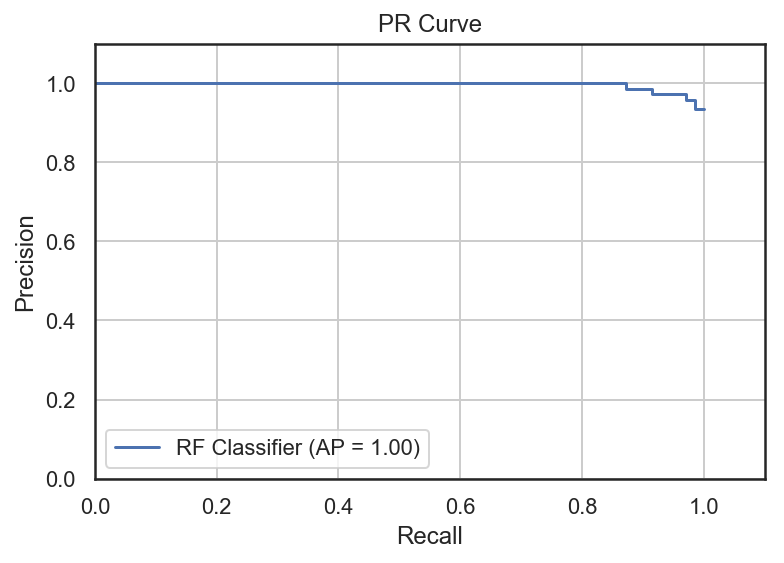

In [13]:
rf_p, rf_r, rf_pr_th = precision_recall_curve(y_test, y_proba_test[:,1])
rf_ap = average_precision_score(y_test, y_proba_test[:,1])
f, ax = plt.subplots()
ax.step(rf_r, rf_p, 'b-', label='RF Classifier (AP = %.2f)' % rf_ap, where='post')
ax.grid(True)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('PR Curve')
ax.set_xlim([0, 1.1 ])
ax.set_ylim([0, 1.1])
ax.legend()
f.savefig('/Users/ness001/data science/plots/bc_pr_curve.png', dpi=200, bbox_inches='tight');

In [14]:
shap.initjs();
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [18]:
explainer.expected_value

[0.3749450594186783, 0.6250549517571926]

In [25]:
X_test.head(3 )

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.1015,0.3014,0.08750
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.1789,0.2551,0.06589
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.1514,0.2837,0.08019


In [21]:
# Explanation of malignant case
shap.force_plot(explainer.expected_value[1 ], shap_values[1][0,:], X_test.iloc[0,:])

In [26]:
# Explanation of benign case
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_test.iloc[1,:])

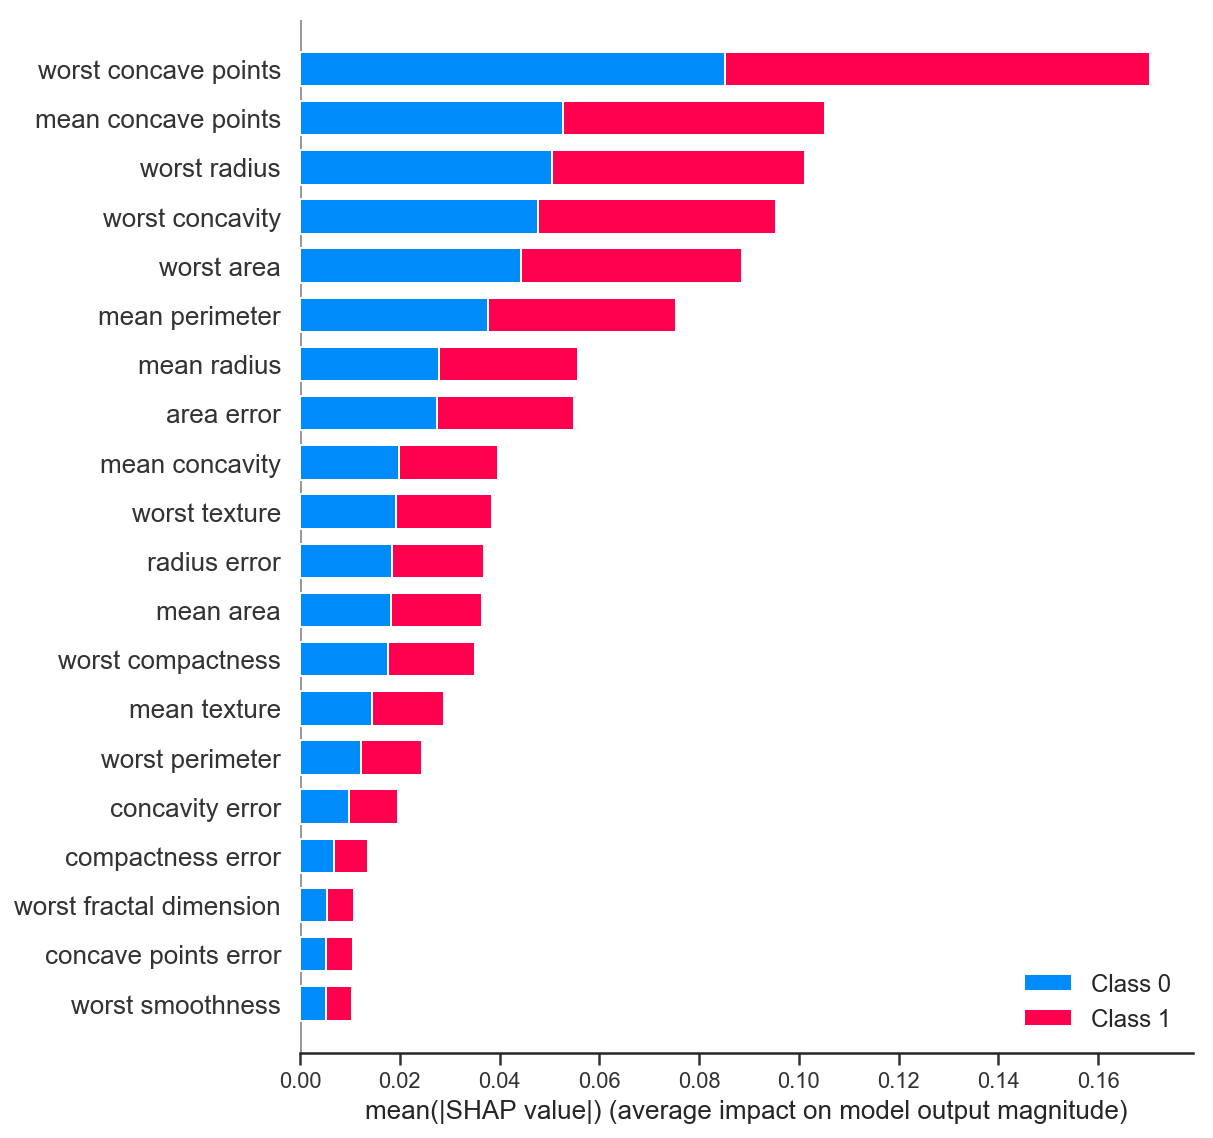

In [27]:
shap.summary_plot(shap_values, X_test)

In [28]:
shap_interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(X_test)

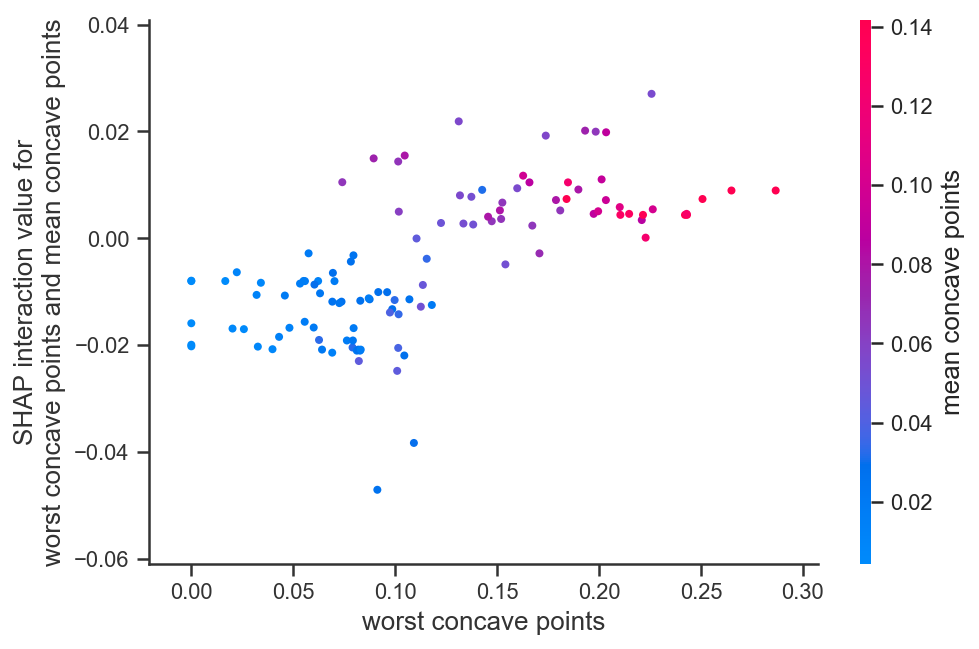

In [30]:
shap.dependence_plot(
    ("worst concave points", "mean concave points"),
    shap_interaction_values[1], X_test
)

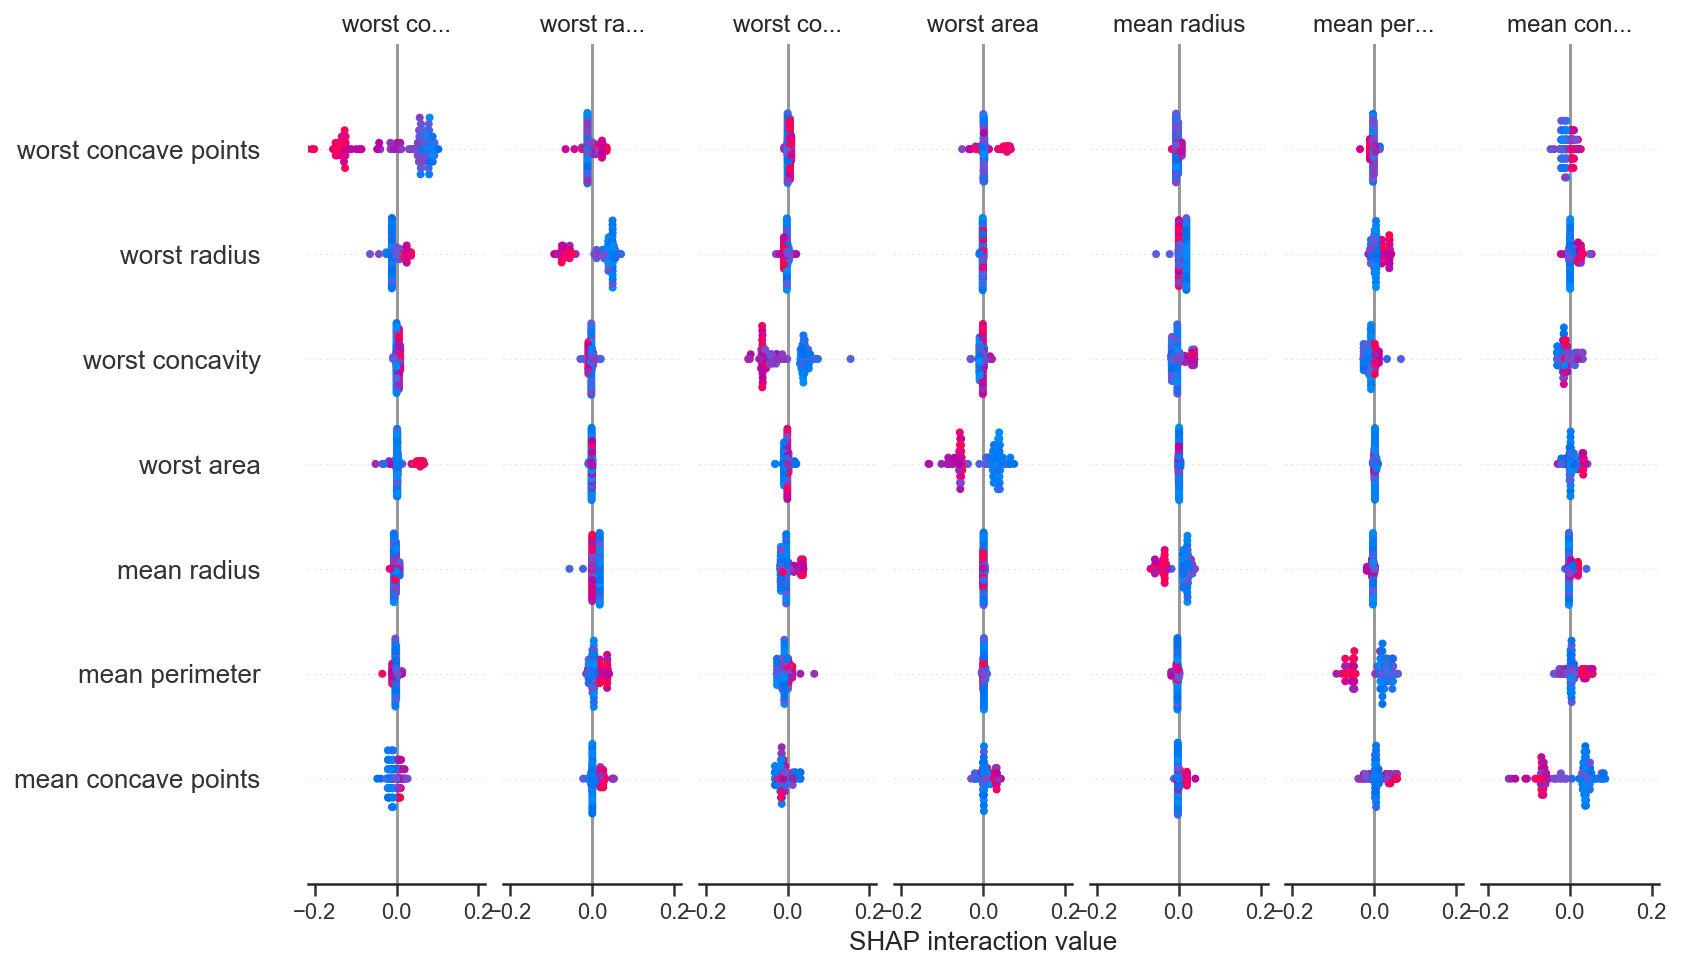

In [29]:
shap.summary_plot(shap_interaction_values[1], X_test)